# ShallowNeuralNetwork(Application)

![](../picture/11.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### 1 加载数据集

这里我们继续使用LR中的图片集.

In [2]:
def load_data():
    '''
    create train set and test set
    make sure you have .h5 file in your dataset
    
    Returns:
    -------
        train_set_x_orig: original train set shape is (209, 64, 64, 3) 
        train_set_y_orig: original train label shape is (209,)
        test_set_x_orig: original test set shape is (50, 64, 64, 3)
        test_set_y_orig: original test label shape is (50,)
        classes: cat or non-cat.
        
    Note:
    ----
        (209, 64, 64, 3): 209 picture,64 width,64 height,3 channel.
    '''
    train_dataset = h5py.File('../data_set/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../data_set/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


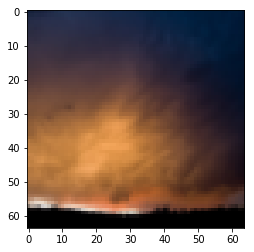

In [4]:
index = 0
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[index]) + ". It's a " + classes[train_y[index]].decode("utf-8") +  " picture.")

y = 1. It's a cat picture.


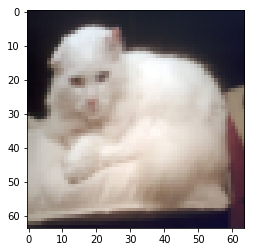

In [5]:
index = 13
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[index]) + ". It's a " + classes[train_y[index]].decode("utf-8") +  " picture.")

这里我将图片形状转换成(n,m)的形式,其中:

n: 特征数

m: 样本个数

标签转换的形式为:(1,m)

**Ps:**

还是那句话,这里如何定义形状是自由的,因为这里只涉及一个转置的问题

In [6]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1).T / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1).T / 255
train_y = train_y.reshape(-1,1).T
test_y = test_y.reshape(-1,1).T
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(12288, 209)
Test_x's shape:(12288, 50)
Train_y's shape:(1, 209)
Test_y's shape:(1, 50)


### 2 Build Model

在构建模型之前,我们需要知道模型的构建逻辑:

(1) 初始化权重和偏置参数$W,b$

```python
def initial_parameters(layer_list):```

注意:

$W$:不能初始化为0,如果初始化为0,那么神经网络做的只是重复线性操作,hidden layer不具有任何作用.其shape(units,inputs)

$b$:可以初始化为0,因为$W$不是0,那么做的就不是重复线性操作.其shape(units,1).这里的1是因为Numpy具有广播(broadcasting)机制.

所以我们可以给定一个layers的列表,统一用for loop一次性加载.

In [7]:
def initial_parameters(layer_list):
    """
    Parameters:
    ----------
        layer_list: layers list. include n_x,layer_1 units,layer_2 units.
    Return:
    ------
        parameters: a dictionary. include weights and bias
    """
    np.random.seed(1) # set random seed.
    L = len(layer_list)
    parameters = {}
    for i in range(1,L):
        parameters['W'+ str(i)] = np.random.randn(layer_list[i],layer_list[i-1]) * 0.001
        parameters['b' + str(i)] = np.zeros(shape=(layer_list[i],1))
    return parameters

In [8]:
layer_list = [train_x.shape[0],4,1]
parameters = initial_parameters(layer_list)
print('W1 shape:',parameters['W1'].shape)
print('b1 shape:',parameters['b1'].shape)
print('W2 shape:',parameters['W2'].shape)
print('b1 shape:',parameters['b2'].shape)

W1 shape: (4, 12288)
b1 shape: (4, 1)
W2 shape: (1, 4)
b1 shape: (1, 1)


可以看到各个hidden layers的形状是正确的

(2) 构建辅助函数:

(2.1) ReLu函数:

$ReLu=max(0,Z)$

```python
def relu(Z):```

这里在隐藏层我们使用ReLu函数.对于Z大于0的部分为本身,小于0的部分为0,这样做的好处是:导数尽量远离0,使得GD下降的更快.

其导数可以使用代码:
```python
np.int64(Z>0)```

因为ReLu的导数当Z大于0的时候就是1(True),小于0的导数是0(False).而上述代码可以直接实现ReLu的导数部分,具体请看Model部分

(2.2) Sigmoid函数:

$sigmoid=\frac{1}{1+e^{-z}}$

```python
def sigmoid(Z):```

因为我们最后做的是二分类,所以我们在输出层(output layer)使用sigmoid函数.

In [9]:
def relu(Z):
    """
    Prameters:
    --------
        Z: linear function value.
    Return:
    ------
        ReLu value.
    """
    return np.maximum(0,Z)

In [10]:
def sigmoid(Z):
    """
    Parameters:
    ----------
        Z: hidden layer output value
    Return:
    ------
        sigmoid value.
    """
    return 1./(1+np.exp(-Z))

(3) 构建模型

在构建模型的时候,我们需要进行四步:

(3.1) **Forward propagation:**

```python
# layer 1
Z1 = np.dot(W1,X) + b1 
A1 = relu(Z1)
# layer 2
Z2 = np.dot(W2,A1) + b2
A2 = sigmoid(Z2)```

注意:

我们可以使用```np.dot```来使两个矩阵相乘.无论你的$W,b,X$的形状是如何的,最终一定要保证$A_2$和$y$的形状是一样的.

(3.2) **Compute loss:**

这里可以使用二分类损失函数

$loss =\frac{1}{m}\cdot ylog(A_2)+(1-y)log(1-A_2)$

(3.3) **Backward Propagation:**

```python
# layer 2
dZ2 = A2 - y 
dW2 = np.dot(dZ2,A1.T) / m
db2 = np.sum(dZ2,axis=1,keepdims=True) /m
# layer 1
dA1 = np.dot(W2.T,dZ2)
dZ1 = np.multiply(dA1,np.int64(Z1>0))
dW1 = np.dot(dZ1,X.T) /m
db1 = np.sum(dZ1,axis=1,keepdims=True) /m```

注意:

因为求导是不改变矩阵的形状的,所以反向传播出来的结果一定要与正向传播的形状是一致的.

这里的```dZ1 = np.multiply(dA1,np.int64(Z1>0))```即完成了ReLu函数的求导,因为

$dz=\left\{\begin{matrix}
0 &if\; z<0 \\ 
 1&if \; z>0 
\end{matrix}\right.$

而```np.int64(Z1>0)```其结果是True或者False.

这里的```np.multiply```指的是逐个元素相乘.当然也可以直接使用$"*"$.

(3.4) **Update:**


```python
W2 -= alpha * dW2
b2 -= alpha * db2
W1 -= alpha * dW1
b1 -= alpha * db1```


In [11]:
def Model(X,y,alpha,Iter,is_print = False):
    
    """
    Implementation shallow neural Network.
    
    Prameters:
    --------
        X: training data
        y: training labels
        Iter: Iterative
        is_print: print loss in some epoch.
        
    """
    n,m = X.shape # 1228,209
    layer_list = [n,4,1] # set layers shape
    parameters = initial_parameters(layer_list)
    W1 = parameters['W1'] # shape 4,n
    b1 = parameters['b1'] # shape 4,1
    W2 = parameters['W2'] # shape 1,4
    b2 = parameters['b2'] # shape 1,1
    cost = []
    
    for iter_ in range(Iter):
        
        #### Forward Propagation ######
        Z1 = np.dot(W1,X) + b1 # shape 4,209
        A1 = relu(Z1) # shape 4,209
        Z2 = np.dot(W2,A1) + b2 # shape 1,209
        A2 = sigmoid(Z2) # shape 1,209

        # caclulate loss value.
        loss = -np.sum(np.multiply(y,np.log(A2))+np.multiply((1-y),np.log(1-A2))) /m

        if is_print and iter_ % 1000 ==0:
            print('after iter{} cost:{}'.format(iter_,loss))
        if iter_ % 100 ==0:
            cost.append(loss)

    
        #### Backward Propagation #####
        dZ2 = A2 - y # shape 1,209
        dW2 = np.dot(dZ2,A1.T) / m
        db2 = np.sum(dZ2,axis=1,keepdims=True) /m
        dA1 = np.dot(W2.T,dZ2)
        dZ1 = np.multiply(dA1,np.int64(Z1>0))
        dW1 = np.dot(dZ1,X.T) /m
        db1 = np.sum(dZ1,axis=1,keepdims=True) /m
        
        #### Update ####
        W2 -= alpha * dW2
        b2 -= alpha * db2
        W1 -= alpha * dW1
        b1 -= alpha * db1
    
    # cache parameters
    parameters['W1'] = W1
    parameters['b1'] = b1
    parameters['W2'] = W2
    parameters['b2'] = b2
    
    return parameters,cost

In [12]:
parameters,cost = Model(train_x,train_y,0.1,3000,is_print=True)

after iter0 cost:0.6931428533871274
after iter1000 cost:0.4489285089103863
after iter2000 cost:0.2604040490018558


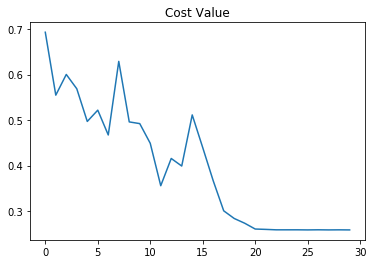

In [13]:
plt.plot(cost);plt.title('Cost Value');plt.show()

### 4 Predict and score

最后我们将模型进行预测和评分.

In [14]:
def predict_score(X,y,parameters):
    """
    Predict and score 
    Prameters:
    ---------
        X: data set
        y: data labels
        Parameters: best weights and bias.
    Return:
    ------
        accuracy:correct rate.
    """
    n,m = X.shape
    W1 = parameters['W1'] 
    b1 = parameters['b1'] 
    W2 = parameters['W2'] 
    b2 = parameters['b2']
    
    Z1 = np.dot(W1,X) + b1 
    A1 = relu(Z1)
    Z2 = np.dot(W2,A1) + b2 
    A2 = sigmoid(Z2) 
    
    predict_y = np.round(A2)
    
    accuracy = (predict_y == y).sum() / m
    return accuracy
    

In [15]:
accuracy = predict_score(test_x,test_y,parameters)
print('The test set correct rate is:',accuracy)

The test set correct rate is: 0.72


In [16]:
accuracy = predict_score(train_x,train_y,parameters)
print('The train set correct rate is:',accuracy)

The train set correct rate is: 0.8851674641148325


可以看到,使用浅层神经网络的结果和LR区别不大,效果都不是很好:

主要有一下几点未处理:

(1) 数据特征工程

(2) 初始化方式

(3) 正则化

(4) 没有达到适合深度

...

这些以后我们都会依依阐述,目前我们只需要了解神经网络的运作模式.

---------

那么如果我们来尝试下一些比较简单是数据

scikite中的iris数据集

In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [18]:
def loadData_iris():
    """
    Returns:
    --------
        X:have two dimensions (sepal length and width).
        Y:labels.
    """
    iris = datasets.load_iris()
    X = iris.data[:100, :2]
    Y = iris.target[:100]
    return X,Y

In [19]:
X,y = loadData_iris()
print('X shape is:',X.shape)
print('y shape is:',y.shape)

X shape is: (100, 2)
y shape is: (100,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

将其转换成我们定义的神经网络能够接受的数据形状

In [21]:
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

X_train shape: (2, 80)
X_test shape: (2, 20)
y_train shape: (1, 80)
y_test shape: (1, 20)


In [22]:
parameters,cost = Model(X_train,y_train,0.1,3000,is_print=True)

after iter0 cost:0.693148433094197
after iter1000 cost:0.059551303048834256
after iter2000 cost:0.03905926878142859


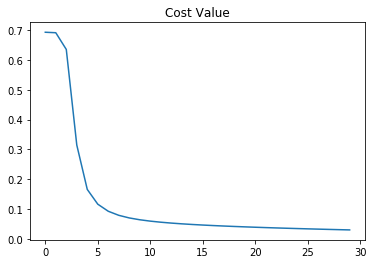

In [23]:
plt.plot(cost);plt.title('Cost Value');plt.show()

In [24]:
accuracy = predict_score(X_test,y_test,parameters)
print('The test set correct rate is:',accuracy)

The test set correct rate is: 1.0


In [25]:
accuracy = predict_score(X_train,y_train,parameters)
print('The test set correct rate is:',accuracy)

The test set correct rate is: 0.9875


可以看到结果几乎是完美的.

# Summary

可以看出神经网对于不同的数据集产生的效果是不同的,因为我们现在还是使用浅层的神经网络,且对于图片我们也没有做其他过多的预处理操作.所以对于我们的图片案例,效果会差许多,但是对于简单的数据集却有很好的效果.